In [ ]:
import os
os.listdir('/content')

['.config',
 'sub-P001_ses-S032_task-Default_run-001_eeg (2).xdf',
 '.ipynb_checkpoints',
 'sample_data']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
!pip install pyxdf
import pyxdf

!pip install mne
import mne

# =====================================================
# 0. USER CONFIG: auto-detect XDF + basic params
# =====================================================

# Root to search for .xdf (Colab default is /content)
search_root = Path("/content")

# Find all .xdf files
xdf_candidates = list(search_root.rglob("*.xdf"))

if len(xdf_candidates) == 0:
    raise FileNotFoundError(
        f"No .xdf files found under {search_root}. "
        f"Upload your LabRecorder .xdf file or change 'search_root'."
    )
elif len(xdf_candidates) == 1:
    xdf_path = xdf_candidates[0]
    print(f"✅ Using XDF file: {xdf_path}")
else:
    print("⚠ Multiple .xdf files found:")
    for p in xdf_candidates:
        print("  -", p)
    raise RuntimeError(
        "Multiple .xdf files detected. Delete extras or set 'xdf_path' manually."
    )

out_dir = Path("bart_p300_output")
out_dir.mkdir(exist_ok=True)

# Preprocessing parameters
l_freq = 0.1
h_freq = 30.0
line_freq = 60.0

# Epoching
tmin, tmax = -0.2, 0.8
baseline = (tmin, 0.0)

# Rejection thresholds (µV) — converted internally to V if you add reject dict
reject_uV = 150.0
flat_uV = 5.0

# P300 window
p3_window = (0.300, 0.450)  # seconds

# Preferred channels for P3 inspection
preferred_targets = ["Fz", "FCz", "Cz", "Pz", "POz"]


# =====================================================
# HELPER
# =====================================================

def safe_str(x):
    """XDF metadata fields often store strings as single-element lists."""
    if isinstance(x, list):
        if len(x) == 0:
            return ""
        return str(x[0])
    return str(x)


# =====================================================
# 1. LOAD XDF
# =====================================================

print("\nLoading XDF...")
streams, _ = pyxdf.load_xdf(str(xdf_path))

eeg_stream = None
marker_stream = None

for s in streams:
    # Name of stream (may be list-wrapped)
    name = safe_str(s.get("info", {}).get("name", [""])).strip().lower()

    # Time series (NumPy array or list)
    ts = s.get("time_series", None)
    if ts is None or len(ts) == 0:
        ch_count = 0
    else:
        if isinstance(ts, np.ndarray):
            ch_count = ts.shape[1]
        else:  # list-of-lists
            ch_count = len(ts[0])

    # EEG = stream with largest channel count
    if eeg_stream is None:
        eeg_stream = s
    else:
        prev_ts = eeg_stream.get("time_series", None)
        if prev_ts is None or len(prev_ts) == 0:
            prev_ch = 0
        else:
            if isinstance(prev_ts, np.ndarray):
                prev_ch = prev_ts.shape[1]
            else:
                prev_ch = len(prev_ts[0])
        if ch_count > prev_ch:
            eeg_stream = s

    # Marker stream: look for typical keywords
    if any(k in name for k in ["marker", "markers", "bart", "event"]):
        marker_stream = s

# Fallback: any 1-channel stream as marker
if marker_stream is None:
    for s in streams:
        ts = s.get("time_series", None)
        if ts is not None:
            if isinstance(ts, np.ndarray) and ts.shape[1] == 1:
                marker_stream = s
                break
            elif isinstance(ts, list) and len(ts[0]) == 1:
                marker_stream = s
                break

print("\nEEG stream detected.")
print("Marker stream detected." if marker_stream else "⚠ WARNING: No explicit marker stream detected.")


✅ Using XDF file: /content/sub-P001_ses-S032_task-Default_run-001_eeg (2).xdf

Loading XDF...


ERROR:pyxdf.pyxdf:found likely XDF file corruption (unpack requires a buffer of 8 bytes), scanning forward to next boundary chunk.



EEG stream detected.
Marker stream detected.


In [ ]:
# =====================================================
# 2. BUILD MNE RAW WITH SCALING + RENAMING + MONTAGE
# =====================================================

eeg_data = np.asarray(eeg_stream["time_series"])  # (samples, channels)
eeg_t = np.asarray(eeg_stream["time_stamps"])

if eeg_t.size < 2:
    raise RuntimeError("EEG stream has too few timestamps to estimate sampling rate.")

sfreq = 1.0 / np.median(np.diff(eeg_t))
print(f"\nEstimated sampling rate: {sfreq:.2f} Hz")

# shape to (n_channels, n_samples)
eeg_arr = eeg_data.T
n_ch, n_samp = eeg_arr.shape
print(f"EEG shape: {n_ch} channels × {n_samp} samples")

# Scale detection
peak = np.nanmax(np.abs(eeg_arr))
if peak > 1e3:
    print("Scaling: interpreting input as µV → converting to V.")
    eeg_arr = eeg_arr * 1e-6
elif peak > 5.0:
    print("Scaling: interpreting input as mV → converting to V.")
    eeg_arr = eeg_arr * 1e-3
else:
    print("Scaling: values appear already in V.")

# Use generic names, then map them to your known 16-channel layout
ch_names = [f"EEG{idx+1:02d}" for idx in range(n_ch)]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(eeg_arr, info, verbose=False)

print("Original channel names:", raw.ch_names)

# If 16-channel actiCAP, rename to your known positions
if len(raw.ch_names) == 16:
    desired_names = [
        "Fz", "Cz", "Pz", "POz",
        "Fp1", "Fp2", "F3", "F4",
        "FCz", "C3", "C4", "CPz",
        "P3", "P4", "O1", "O2",
    ]
    mapping = dict(zip(raw.ch_names, desired_names))
    raw.rename_channels(mapping)
    print("Renamed channels to:", raw.ch_names)
else:
    print(f"⚠ Expected 16 EEG channels, got {len(raw.ch_names)} – keep generic names or adjust mapping.")

# Attach standard 10–20 montage so topomap knows electrode positions
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage, on_missing="warn")
print("Montage set.")

# =====================================================
# 3. MARKERS → EVENTS (FIXED VERSION)
# =====================================================

def safe_label(x):
    """Extract clean event code before semicolon."""
    if isinstance(x, list):
        if len(x) == 0:
            return ""
        x = x[0]
    x = str(x)
    return x.split(";")[0].strip()   # keep only event name, drop metadata


event_samples = []
event_ids = {}

if marker_stream is None:
    raise RuntimeError("No marker stream found; cannot build events.")

m_ts = np.asarray(marker_stream["time_stamps"])
m_data = marker_stream["time_series"]

print(f"\nEEG time range: {eeg_t[0]:.3f} → {eeg_t[-1]:.3f}")
print(f"Marker time range: {m_ts[0]:.3f} → {m_ts[-1]:.3f}")

last_sample_used = -1

for t, raw_val in zip(m_ts, m_data):
    label = safe_label(raw_val)

    # Skip empty markers
    if label == "":
        continue

    # Map event label to short integer code
    if label not in event_ids:
        event_ids[label] = len(event_ids) + 1

    # Find closest EEG sample
    idx = int(np.searchsorted(eeg_t, t))

    # Clamp inside bounds
    idx = max(0, min(idx, len(eeg_t)-1))

    # Prevent duplicate sample indices (can happen when markers cluster)
    if idx == last_sample_used:
        idx += 1
        idx = min(idx, len(eeg_t)-1)

    last_sample_used = idx

    event_samples.append([idx, 0, event_ids[label]])

events = np.array(event_samples, dtype=int)

print(f"\nTotal markers aligned: {len(events)}")
print("Event label → code mapping:")
for k, v in event_ids.items():
    print(f"  {k}: {v}")

# Explosion event code
explode_labels = [k for k in event_ids if "explode" in k.lower()]

if not explode_labels:
    raise RuntimeError("No event label contains 'explode'. Check XDF markers.")

explode_label = explode_labels[0]  # now safe, all explosions have same label
explode_code = event_ids[explode_label]

print(f"\nUsing EXPLODE event code: {explode_code} ({explode_label})")



Estimated sampling rate: 512.00 Hz
EEG shape: 16 channels × 386048 samples
Scaling: interpreting input as µV → converting to V.
Original channel names: ['EEG01', 'EEG02', 'EEG03', 'EEG04', 'EEG05', 'EEG06', 'EEG07', 'EEG08', 'EEG09', 'EEG10', 'EEG11', 'EEG12', 'EEG13', 'EEG14', 'EEG15', 'EEG16']
Renamed channels to: ['Fz', 'Cz', 'Pz', 'POz', 'Fp1', 'Fp2', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CPz', 'P3', 'P4', 'O1', 'O2']
Montage set.

EEG time range: 530248.687 → 531002.685
Marker time range: 530250.377 → 531002.785

Total markers aligned: 840
Event label → code mapping:
  BART_INSTRUCTIONS_PAGE: 1
  BART_INSTRUCTIONS_END: 2
  BART_TRIAL_START: 3
  BART_PUMP: 4
  BART_COLLECT: 5
  BART_FIXATION_START: 6
  BART_FIXATION_END: 7
  BART_ITI: 8
  BART_EXPLODE: 9
  BART_PRACTICE_END: 10

Using EXPLODE event code: 9 (BART_EXPLODE)


In [ ]:
# =====================================================
# 4. PREPROCESSING
# =====================================================

print("\nFiltering (bandpass + notch) and re-referencing...")
raw.filter(l_freq, h_freq, fir_design="firwin")
raw.notch_filter(line_freq)
raw.set_eeg_reference("average")

# =====================================================
# 5. EPOCHING AROUND EXPLODE
# =====================================================

explode_events = events[events[:, 2] == explode_code]
print(f"\nNumber of EXPLODE markers in events: {len(explode_events)}")

epochs = mne.Epochs(
    raw,
    explode_events,
    event_id={"EXPLODE": explode_code},
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    preload=True,
)

print(f"Epochs extracted: {len(epochs)}")

if len(epochs) == 0:
    print("⚠ Epochs object is empty.")
    print("  - Check event timing, tmin/tmax, and explosion markers.")
    try:
        epochs.plot_drop_log()
    except Exception:
        pass
    raise RuntimeError("No EXPLODE epochs were created.")



Filtering (bandpass + notch) and re-referencing...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz 


Available channels in evoked object:
['Fz', 'Cz', 'Pz', 'POz', 'Fp1', 'Fp2', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CPz', 'P3', 'P4', 'O1', 'O2']
Using these channels for P300 peak detection: ['Fz', 'FCz', 'Cz', 'Pz', 'POz']


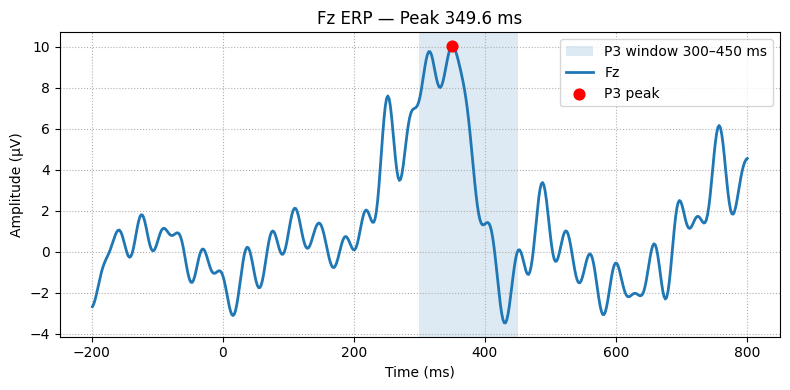

Saved: bart_p300_output/erp_Fz.png


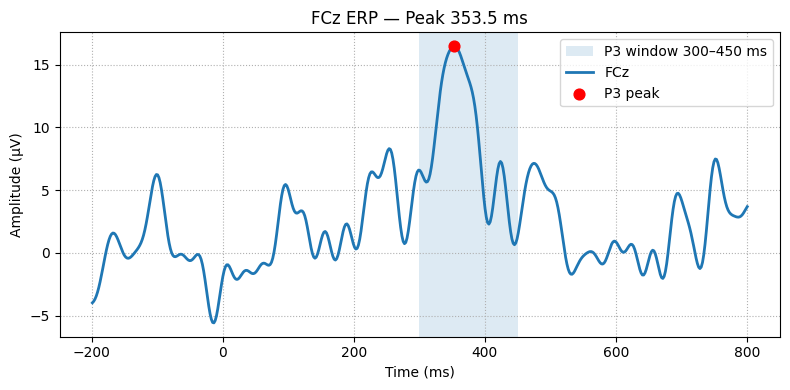

Saved: bart_p300_output/erp_FCz.png


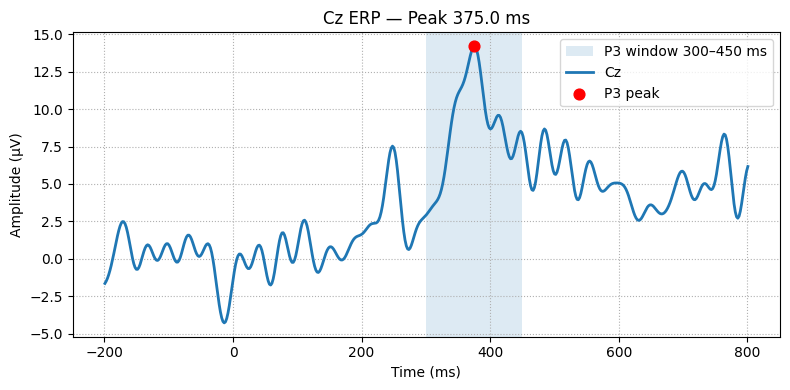

Saved: bart_p300_output/erp_Cz.png


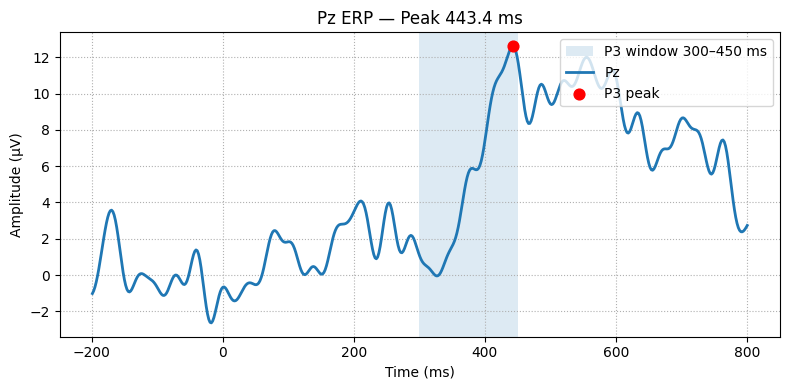

Saved: bart_p300_output/erp_Pz.png


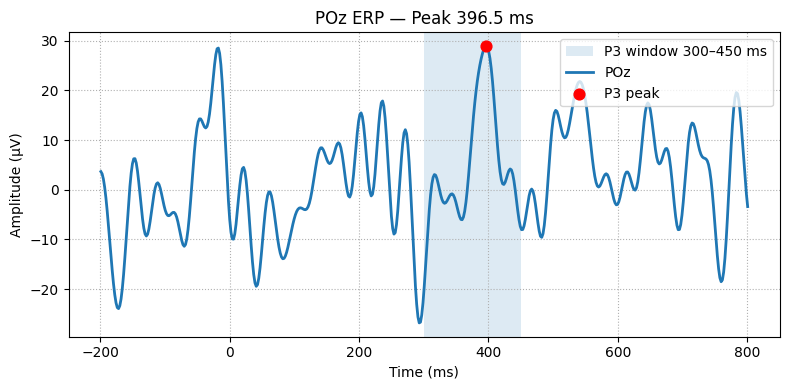

Saved: bart_p300_output/erp_POz.png


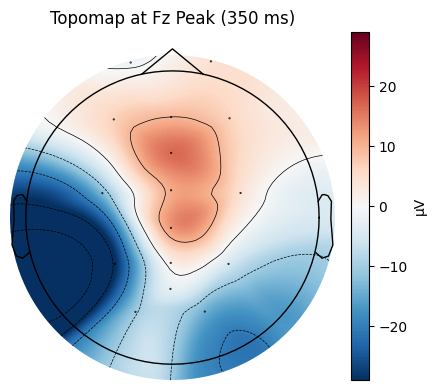

Saved: bart_p300_output/topomap_Fz.png


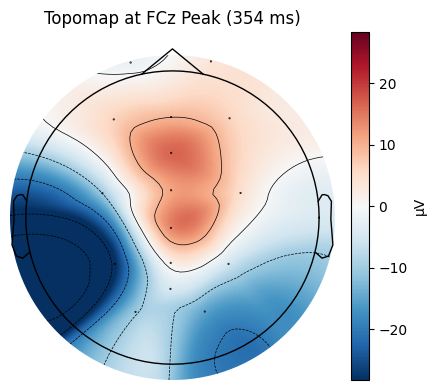

Saved: bart_p300_output/topomap_FCz.png


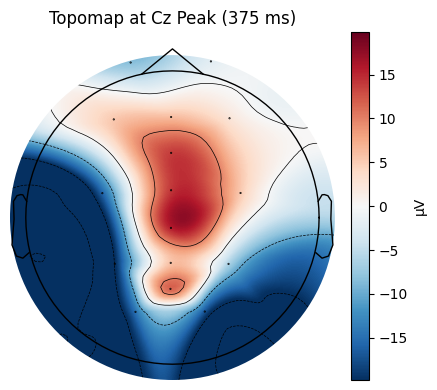

Saved: bart_p300_output/topomap_Cz.png


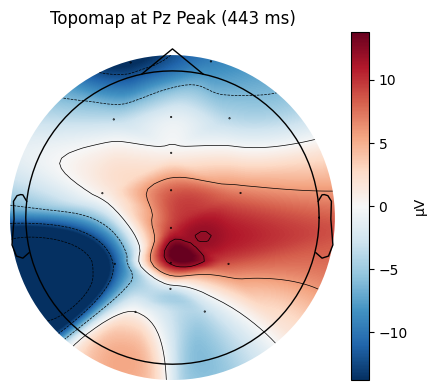

Saved: bart_p300_output/topomap_Pz.png


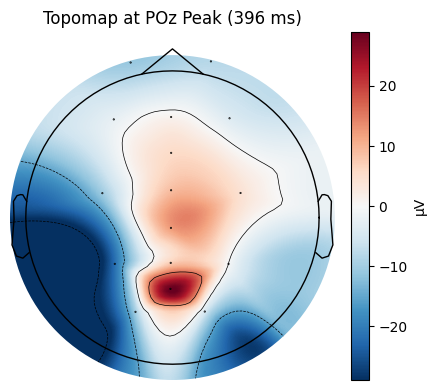

Saved: bart_p300_output/topomap_POz.png

✅ Pipeline complete. ERPs and topomaps saved in: bart_p300_output


In [ ]:
# =====================================================
# 6. ERP + P300 PEAK DETECTION
# =====================================================

ev = epochs.average()
times = ev.times

print("\nAvailable channels in evoked object:")
print(ev.ch_names)

available_targets = [ch for ch in preferred_targets if ch in ev.ch_names]

if len(available_targets) == 0:
    print("⚠ None of the preferred P3 channels found.")
    print("   Falling back to first 3 channels in ev.ch_names.")
    available_targets = ev.ch_names[:3]
else:
    print("Using these channels for P300 peak detection:", available_targets)

peak_times = {}

def plot_channel(ch_name):
    ch_idx = ev.ch_names.index(ch_name)
    erp = ev.data[ch_idx] * 1e6  # µV

    # Peak inside P3 window
    m1 = np.argmin(np.abs(times - p3_window[0]))
    m2 = np.argmin(np.abs(times - p3_window[1]))
    if m2 <= m1:
        raise RuntimeError("P3 window indices invalid – check p3_window and epochs.times.")

    seg = erp[m1:m2]
    peak_idx = np.argmax(seg) + m1
    peak_amp = erp[peak_idx]
    peak_time_ms = times[peak_idx] * 1000.0

    plt.figure(figsize=(8, 4))
    plt.axvspan(p3_window[0]*1000, p3_window[1]*1000, alpha=.15,
                label=f"P3 window {int(p3_window[0]*1000)}–{int(p3_window[1]*1000)} ms")
    plt.plot(times*1000, erp, label=ch_name, linewidth=2)
    plt.scatter([peak_time_ms], [peak_amp], color='red', s=60, zorder=5, label="P3 peak")

    plt.title(f"{ch_name} ERP — Peak {peak_time_ms:.1f} ms")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True, linestyle=':')
    plt.legend(loc="upper right")
    fn = out_dir / f"erp_{ch_name}.png"
    plt.tight_layout()
    plt.savefig(fn, dpi=300)
    plt.show()
    print("Saved:", fn)

    return times[peak_idx]  # seconds

for ch in available_targets:
    peak_times[ch] = plot_channel(ch)

# =====================================================
# 7. TOPOMAPS AT EACH CHANNEL'S PEAK
# =====================================================

from mne.viz import plot_topomap

if not ev.info["dig"]:
    print("⚠ No EEG sensor positions found in ev.info['dig']. Skipping topomaps.")
else:
    for ch, ptime in peak_times.items():
        idx = np.argmin(np.abs(times - ptime))
        topo_vals = ev.data[:, idx] * 1e6  # µV

        fig, ax = plt.subplots(figsize=(5, 4))
        try:
            im, _ = plot_topomap(topo_vals, ev.info, axes=ax, show=False, vlim=(None, None))
        except TypeError:
            # Older MNE: no vlim argument
            im, _ = plot_topomap(topo_vals, ev.info, axes=ax, show=False)

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="µV")
        ax.set_title(f"Topomap at {ch} Peak ({ptime*1000:.0f} ms)")
        fn = out_dir / f"topomap_{ch}.png"
        plt.tight_layout()
        plt.savefig(fn, dpi=300)
        plt.show()
        print("Saved:", fn)

print("\n✅ Pipeline complete. ERPs and topomaps saved in:", out_dir)

In [ ]:
for t,val in zip(marker_stream["time_stamps"], marker_stream["time_series"]):
    print(val)

print("EEG:", eeg_t[0], "→", eeg_t[-1])
print("Markers:", m_ts[0], "→", m_ts[-1])

['BART_INSTRUCTIONS_PAGE;timestamp=23.271240600035526;page=1;title=Welcome']
['BART_INSTRUCTIONS_PAGE;timestamp=24.050688500050455;page=2;title=Controls']
['BART_INSTRUCTIONS_PAGE;timestamp=24.574905600049533;page=3;title=Risk']
['BART_INSTRUCTIONS_PAGE;timestamp=25.06869570002891;page=4;title=Neurofeedback']
['BART_INSTRUCTIONS_PAGE;timestamp=25.668697600020096;page=5;title=Practice']
['BART_INSTRUCTIONS_END;timestamp=25.66875459998846;']
['BART_TRIAL_START;timestamp=41.60603889997583;block=Practice;trial=1;expoint=25;nf=NONE;z=']
['BART_PUMP;timestamp=42.10745610005688;block=Practice;trial=1;pump=1;key=left']
['BART_PUMP;timestamp=42.94165950000752;block=Practice;trial=1;pump=2;key=right']
['BART_PUMP;timestamp=43.94144560000859;block=Practice;trial=1;pump=3;key=right']
['BART_PUMP;timestamp=44.90759279998019;block=Practice;trial=1;pump=4;key=right']
['BART_PUMP;timestamp=45.82462630001828;block=Practice;trial=1;pump=5;key=right']
['BART_PUMP;timestamp=47.67549529997632;block=Practic